# UC SD Micromasters - Python for Data Science
# Craigslist Used Cars Dataset



In [90]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import and read dataset

First, look at downloaded file from https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download.

In [91]:
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

craigslist-carstrucks-data.zip
vehicles.csv



Unzip the file and extract into the data folder.

In [93]:
# how to from https://www.kaggle.com/mchirico/how-to-read-datasets
import zipfile
Dataset = "craigslist-carstrucks-data"

with zipfile.ZipFile("./data/"+Dataset+".zip","r") as z:
    z.extractall("./data")

Import data as pandas dataframe.

In [103]:
cars_raw = pd.read_csv("./data/vehicles.csv")

In [104]:
# dataframe shape
print("Number of rows:",cars_raw.shape[0])
print()
print("Number of columns",cars_raw.shape[1])

Number of rows: 539759

Number of columns 25


## Clean data set

Remove unnecessary columns and null values. Let's look at the proportion of no-null values as percent of total number of rows. This will give us an idea of which variables contain actual data vs those that are mostly `NULL`

In [96]:
no_null_prc = (cars_raw.count()/len(cars_raw)).round(2)*100
no_null_prc

id              100.0
url             100.0
region          100.0
region_url      100.0
price           100.0
year            100.0
manufacturer     96.0
model            99.0
condition        56.0
cylinders        60.0
fuel             99.0
odometer         82.0
title_status     99.0
transmission     99.0
vin              58.0
drive            71.0
size             31.0
type             73.0
paint_color      68.0
image_url       100.0
description     100.0
county            0.0
state           100.0
lat              98.0
long             98.0
dtype: float64

Select columns of interest that have greater than 80% of actual data.

In [105]:
cols_to_use = list(no_null_prc[no_null_prc>=80].index)
cols_to_use

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'image_url',
 'description',
 'state',
 'lat',
 'long']

Remove the first 4 columns: these columns only contain the id and other url information. Not needed for this analysis.

In [106]:
cols_not_needed = list(cars_raw.columns[0:4])
cols_not_needed.extend(['description','image_url'])
cols_not_needed

['id', 'url', 'region', 'region_url', 'description', 'image_url']

In [198]:
cars = cars_raw[[name for name in cols_to_use if name not in cols_not_needed]]
cars = cars.dropna()
cars.sample(10)

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state,lat,long
375798,2800,1999.0,toyota,4runner sr5,gas,222500.0,clean,automatic,ca,33.8186,-117.9730
109164,1400,1994.0,nissan,pathfinder,gas,151000.0,clean,automatic,fl,26.6930,-81.9125
464722,12000,2017.0,ford,fusion hybrid se,hybrid,68000.0,lien,automatic,tx,28.7221,-96.2607
160219,20959,2018.0,subaru,wrx premium,gas,14000.0,rebuilt,automatic,ut,40.7190,-112.0250
182793,5995,2010.0,subaru,legacy,gas,170439.0,clean,automatic,nj,40.0293,-74.9497
280161,35751,2016.0,chevrolet,silverado 1500,gas,36772.0,clean,automatic,mo,38.3826,-93.7734
49491,2900,2006.0,hyundai,azera limited,gas,158000.0,clean,automatic,pa,40.4598,-79.8224
81961,25990,2014.0,ford,f-150,gas,94442.0,clean,automatic,al,33.6696,-86.8176
315358,4195,2011.0,hyundai,santa fe se awd,gas,192595.0,clean,automatic,md,39.1564,-75.4955
460776,5495,2009.0,chevrolet,hhr,other,104280.0,clean,automatic,ia,43.2705,-91.7265


### Description of the variables:

Categorical variables:
- manufacturer
- model
- fuel
- title_status
- transmission
- state

Numerical variables:
- price
- year
- odometer

Location variables:
- lat
- long

Date variables:
- year

## Preliminary data exploration and further cleaning

Firts, lets look at the distribution of the numeric variables : 

- Median price is \$10900 while the max value is $4.3 billion!
- Medin odometer reading is 93827 mi.
- Median year is 2012

Here are some more additiona statistics.

In [199]:
cars.describe(percentiles=[0.05,0.1,0.5,0.9,0.95]).transpose()

,count,mean,std,min,5%,10%,50%,90%,95%,max
price,405819.0,158396.881410,2.055869e+07,0.0000,0.0000,1750.0000,10900.0000,27988.0000,34000.0000,4.198287e+09
year,405819.0,2010.920068,6.819119e+00,1908.0000,2000.0000,2003.0000,2012.0000,2017.0000,2018.0000,2.021000e+03
odometer,405819.0,100039.416912,1.026830e+05,0.0000,12434.9000,23089.0000,93827.0000,178079.4000,203560.0000,1.000000e+07
lat,405819.0,38.687136,5.785775e+00,-84.9114,28.6036,30.6007,39.2868,45.4881,47.6496,8.451480e+01
long,405819.0,-94.201507,1.781262e+01,-166.3770,-122.5380,-121.3020,-88.0490,-74.8883,-73.0805,1.610160e+02


Remove vehicles with prices and odometer readings that are slightly more than the 90% percentile and less than the 1% percentile. This will get rid of extreme outliers. 

In [200]:
cars = cars[(cars.price<=30000) & (cars.price>1000) & (cars.odometer<=180000) &  (cars.odometer>=2000)]

A large majority of values in transmission are laballed as  "other":

In [201]:
cars.transmission.value_counts()

automatic    264175
other         18398
manual        15848
Name: transmission, dtype: int64

We'll assume transmission labeled "other" is automatic:

In [202]:
cars['transmission'] = np.where(cars.transmission == "other","automatic",cars.transmission)

A very small minority of `title_status` values are either labeled "missing" or "parts only". So we'll remove those variables from the dataset.

In [203]:
cars.title_status.value_counts()

clean         284895
rebuilt         8434
salvage         3186
lien            1780
missing           95
parts only        31
Name: title_status, dtype: int64

In [204]:
# remove 'missing' and 'parts only'
keep = ['clean','rebuilt','salvage','lien']
cars = cars[cars['title_status'].isin(keep)]

Let's take a look at the distribution of prices by fuel type:

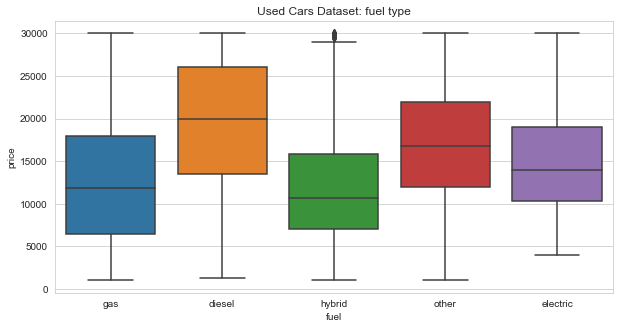

In [205]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
sns.boxplot(x='fuel',y='price',data=cars).set_title('Used Cars Dataset: fuel type');

Vehicles with fuel type as  "other" can be removed from the analysis since it would be difficult to identify the fuel to for those:

In [206]:
cars.fuel.value_counts()

gas         274632
diesel       11733
other         8601
hybrid        2783
electric       546
Name: fuel, dtype: int64

In [207]:
cars = cars[~cars['fuel'].isin(['other'])]

Lets see the number of vehicles grouped by year on a line plot: notice that most vehicles have years between the late 90's and early 2020.

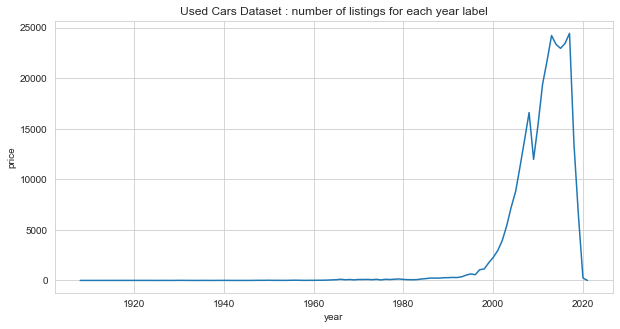

In [208]:
grouped_by_year = cars.groupby('year').count().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='year',y='price',data=grouped_by_year).set_title('Used Cars Dataset : number of listings for each year label');

For this analysis we'll look at listings between 1999 and 2019:

In [209]:
cars = cars[(cars.year>=1999) & (cars.year<=2019)]

Now let's look at the boxplot of transmission type vs price. Notice that vehicles with an automatic transmission tend to be at slightly higher price:

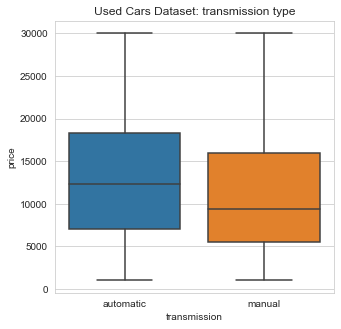

In [210]:
plt.figure(figsize=(5,5))
sns.boxplot(x='transmission',y='price',data=cars).set_title('Used Cars Dataset: transmission type');

Now let's look a the boxplot of title status vs price. Interestingly, vehicles with a lien tend to be higher priced. This could be because those vehicles typically are being sold to pay off creditors (banks, dealerships, etc.)

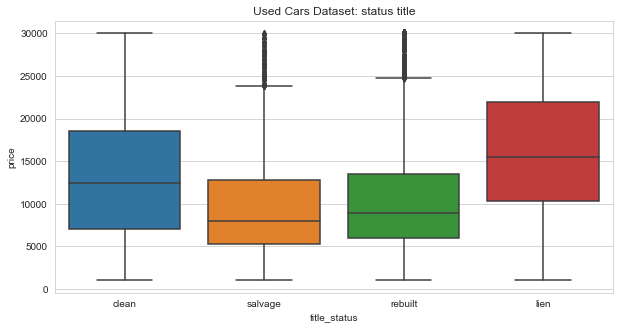

In [211]:
plt.figure(figsize=(10,5))
sns.boxplot(x='title_status',y='price',data=cars).set_title('Used Cars Dataset: status title');

Let's look at a plot of a joint histogram using exagonal bins of the price with odometer reading: notice the down-ward non-linear nature of of the data.

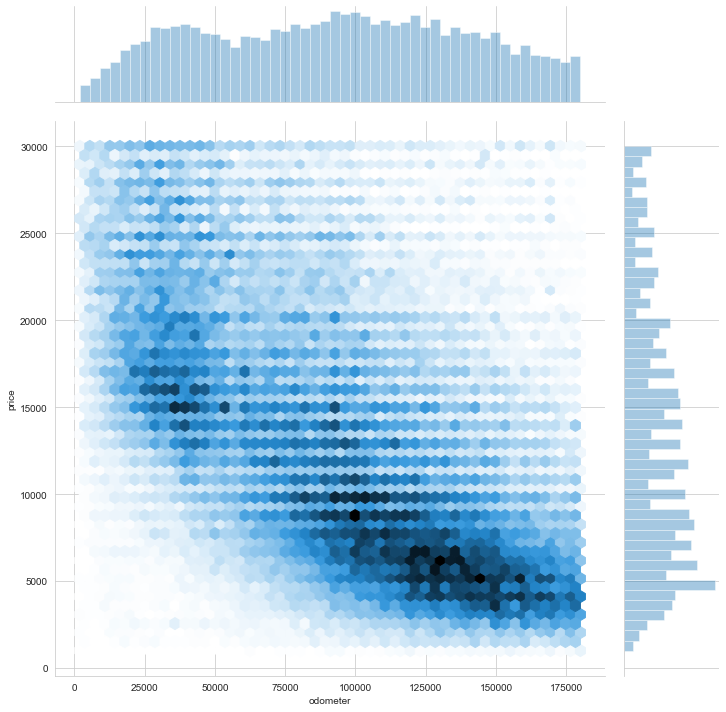

In [212]:
sns.jointplot("odometer", "price", data=cars,size=10,kind = "hex");

Now let's look at the distribution of price for each manufacturer and model type.

In [163]:
cars[['manufacturer','price','odometer']].groupby('manufacturer').median().reset_index().sort_values(by="price",ascending=False)

,manufacturer,price,odometer
1,alfa-romeo,24995.0,23701.0
2,aston-martin,23986.0,31980.0
32,ram,20763.5,94689.0
13,gmc,15800.0,106000.0
19,jeep,14995.0,83974.0
33,rover,13995.0,91497.0
3,audi,13690.0,86000.0
12,ford,13495.0,97495.0
7,chevrolet,12999.0,94000.0
25,mercedes-benz,12999.0,87000.0
